# Background at LGS channel

## Thermal flux

Thermal flux is computed for the LGS channel as

$F_{th} = B(T) \ \epsilon_{tot} \ \Omega \ p_{size}^2 \ Q_{CCD_{220}}$ 

where $B(T)$ is the blackbody radiance, $\epsilon_{tot}$ is the total emissivity (i.e. emissivity of telescope + MORFEO up to LGS channel included), $\Omega$ is the solid angle subtended by the LGS WFS lenslet array, $p_{size}$ is the pixel size of the detector and $Q_{CCD_{220}}$ is the quantum efficiency of the detector.

$\underline{NOTE}$: Flux unit is PHOTLAM from synphot, defined as: PHOTLAM = ph/s/cm$^2$/Angstrom.

  points: [3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900.
 5000. 5100. 5200. 5300. 5400. 5500.]
  lookup_table: [-1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16] [synphot.models]
/var/folders/bz/hhfc34sj5m53p6z7z2vq77jh0000gn/T/ipykernel_15063/3332644828.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 44000)


PHOTLAM = ph/s/cm$^2$/Angstrom


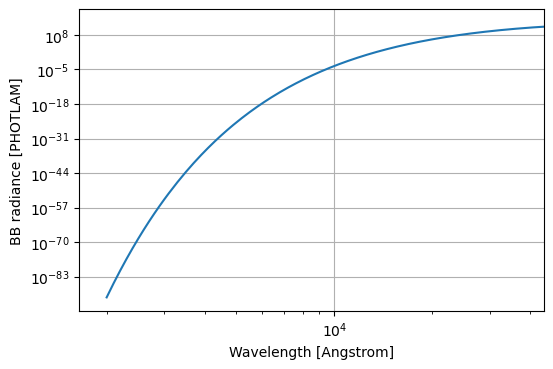

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.morfeo_transmissive_systems import MorfeoLgsChannelTransmissiveSystem_001
from arte.photometry.transmissive_elements_catalogs import MorfeoTransmissiveElementsCatalog, \
    DetectorsTransmissiveElementsCatalog

lgs_ch = MorfeoLgsChannelTransmissiveSystem_001()
waveset = lgs_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)
# plt.ylim(1e-25, 1e20)

print('PHOTLAM = ph/s/cm$^2$/Angstrom')

In [2]:
#PARAMETERS
lenslet_diam = 30 * u.mm
lenslet_f = 3.21125* u.mm
px_size = 9 * u.um
omega = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
print(omega)

3.0039180614432066 sr


Text(0.5, 0, 'Wavelength [Angstrom]')

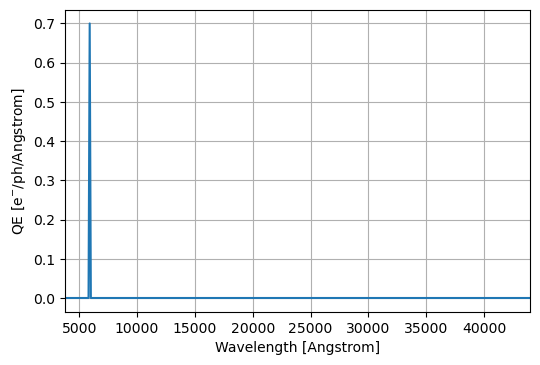

In [3]:
cblue = DetectorsTransmissiveElementsCatalog.c_blue_qe_001()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, cblue.transmittance(waveset))
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)

5899.999999999998 Angstrom
3.9835688974884746e-25 cm2 PHOTLAM
3.983568897488493e-23 Angstrom cm2 PHOTLAM


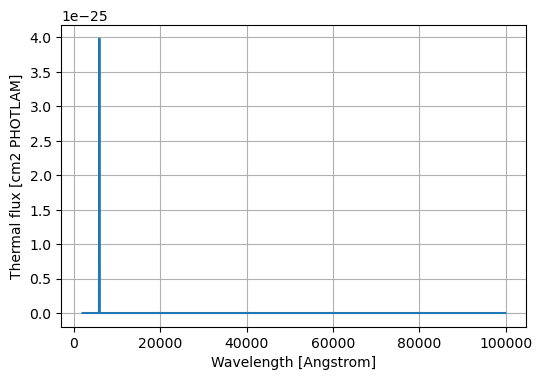

In [4]:
#THERMAL FLUX AT LGS CHANNEL
# photlam_explicit = u.ph / u.s / u.cm**2 / u.Angstrom / units.PHOTLAM
th_flux = (bb * lgs_ch.emissivity * cblue.transmittance)(waveset) * omega.value * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \dfrac{D}{N_{subap}} \ p_{scale}^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $D$ is the telescope diameter, $N_{subap}$ is the number of subapertures and $p_{scale}$ is pixel-scale.

Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)
Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)


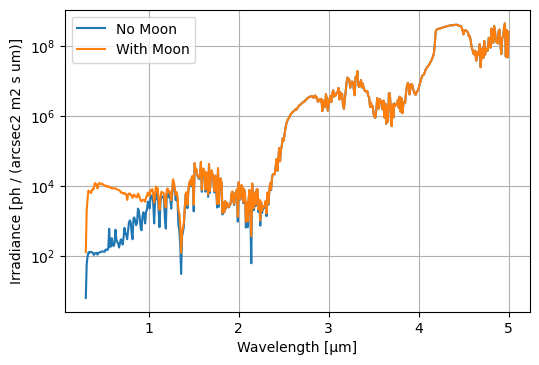

In [5]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [6]:
px_scale = 1.2 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

0.002809781918722872 cm2 PHOTLAM
0.07404803770810332 cm2 PHOTLAM


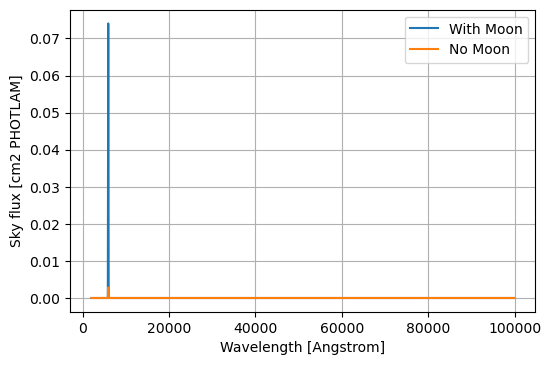

In [7]:
D_tel = 38.542 * u.m
N_subap = 68

sky_no_moon_at_ccd = (sky_ss_no_moon * lgs_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * lgs_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(sky_no_moon_at_ccd.max())
print(sky_fullmoon_at_ccd.max())

In [12]:
id_600nm = np.where(np.isclose(np.array(waveset), 6000., atol=10))

print(sky_flux_no_moon[id_600nm])
print(sky_flux_fullmoon[id_600nm])
print((sky_ss_fullmoon)(waveset)[id_600nm] * (D_tel.to(u.cm) / N_subap)**2)

[3.68008277e-06] ph / (Angstrom cm2 s)
[9.19285023e-05] ph / (Angstrom cm2 s)
[0.39354449] cm2 PHOTLAM


## Total background

In [ ]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [ ]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

# Background at Reference channel

## Thermal flux

Thermal flux is computed for the Reference channel as

$F_{th} = B(T) \ \epsilon_{tot} \ \Omega \ \ p_{size}^2 \ Q_{CCD_{220}}$ 

where $B(T)$ is the blackbody radiance, $\epsilon_{tot}$ is the total emissivity (i.e. emissivity of telescope + MORFEO up to Reference channel included), $\Omega$ is the solid angle subtended by the R WFS lenslet array, $p_{size}$ is the pixel size of the detector and $Q_{CCD_{220}}$ is the quantum efficiency of the detector.

$\underline{NOTE}$: Flux unit is PHOTLAM from synphot, defined as: PHOTLAM = ph/s/cm$^2$/Angstrom.

In [ ]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.morfeo_transmissive_systems import MorfeoReferenceChannelTransmissiveSystem_001
from arte.photometry.transmissive_elements_catalogs import MorfeoTransmissiveElementsCatalog

r_ch = MorfeoReferenceChannelTransmissiveSystem_001()
waveset = r_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)

In [ ]:
#PARAMETERS
lenslet_diam = 5.76 * u.mm
lenslet_f = 8.8 * u.mm
px_size = 24 * u.um
omega = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
print(omega)

In [ ]:
ccd220 = MorfeoTransmissiveElementsCatalog.ccd220_qe_001()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, ccd220.transmittance(waveset))
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)

In [ ]:
#THERMAL FLUX AT REFERENCE CHANNEL
th_flux = (bb * r_ch.emissivity * ccd220.transmittance)(waveset) * omega.value * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \left(\dfrac{D}{N_{subap}}\right)^2 \ p_{scale}^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $D$ is the telescope diameter, $N_{subap}$ is the number of subapertures and $p_{scale}$ is pixel-scale.

In [ ]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [ ]:
px_scale = 0.15 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

In [ ]:
D_tel = 38.542 * u.m
N_subap = 10

sky_no_moon_at_ccd = (sky_ss_no_moon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(sky_no_moon_at_ccd.max())
print(sky_fullmoon_at_ccd.max())

## Total background flux

In [ ]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [ ]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

## Sky background

Sky background in [e$^-$/s/pix/m$^2$/arcsec$^2$].

In [ ]:
sky_bkg_no_moon = sky_no_moon_at_ccd / px_scale**2 * (N_subap / D_tel.to(u.m))**2
sky_bkg_fullmoon = sky_fullmoon_at_ccd / px_scale**2 * (N_subap / D_tel.to(u.m))**2

plt.plot(waveset, sky_bkg_fullmoon, label='With Moon')
plt.plot(waveset, sky_bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
# plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

print('Sky background without Moon: %s' %np.trapz(sky_bkg_no_moon, waveset))
print('Sky background with Moon: %s' %np.trapz(sky_bkg_fullmoon, waveset))

# Background at Low Order channel

## Thermal flux

Thermal flux is computed for the Low Order channel as

$F_{th} = B(T) \ [\epsilon_1 \ \Omega_1 + \epsilon_2 \ (\Omega_2 - \Omega_1)] \ p_{size}^2 \ T_{CF} Q_{CRED1}$ 

where $B(T)$ is the blackbody radiance, $\epsilon_1$ is the emissivity from telescope + MORFEO up to the LO WFS lenslet array, $\epsilon_2$ is the emissivity due to unwanted ra after the lenslet array, $\Omega_1$ is the solid angle subtended by the lenslet array, $\Omega_2$ is the solid angle subtended by the cold stop, $T_{CF}$ is the cold filters transmission and $Q_{CRED1}$ is the quantum efficiency of the detector.
$\Omega$ is the solid angle subtended by the R WFS lenslet array and $d$ is the lenslet array size.

$\underline{NOTE}$: Flux unit is PHOTLAM from synphot, defined as: PHOTLAM = ph/s/cm$^2$/Angstrom.

$\underline{NOTE}$: It is assumed $\epsilon_2$ = 1. 

In [ ]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.morfeo_transmissive_systems import MorfeoLowOrderChannelTransmissiveSystem_001
from arte.photometry.transmissive_elements_catalogs import MorfeoTransmissiveElementsCatalog

lo_ch = MorfeoLowOrderChannelTransmissiveSystem_001()
waveset = lo_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)

In [ ]:
#PARAMETERS
lenslet_diam = 5.76 * u.mm
lenslet_f = 87.7 * u.mm
px_size = 24 * u.um
cs_oversiz = 0.65
cs_ccd = 38.83 * u.mm
omega_pup = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
omega_cam = np.pi / 4 * (lenslet_diam * (1 + cs_oversiz))**2 / (
                        cs_ccd**2 + (lenslet_diam * (1 + cs_oversiz) / 2)**2) * u.sr
print(omega_pup)
print(omega_cam)

In [ ]:
c_red1_qe = MorfeoTransmissiveElementsCatalog.c_red_one_qe_001()
c_red1_filt = MorfeoTransmissiveElementsCatalog.c_red_one_filters_001()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, c_red1_qe.transmittance(waveset), label='QE')
plt.plot(waveset, c_red1_filt.transmittance(waveset), label='Cold filters')
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.legend()

In [ ]:
#THERMAL FLUX AT REFERENCE CHANNEL
e1 = lo_ch.emissivity(waveset)
e2 = 1

th_flux = (bb * c_red1_qe.transmittance * c_red1_filt.transmittance)(waveset) * (e1 * omega_pup.value + e2 * (omega_cam - omega_pup).value) * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \dfrac{A}{N_{subap}^2} \ p^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $A$ is the telescope surface, $N_{subap}$ is the number of subapertures and $p$ is pixel-scale.

In [ ]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [ ]:
px_scale = 9e-3 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

In [ ]:
A_tel = 1028.613 * u.m**2
N_subap = 2

sky_no_moon_at_ccd = (sky_ss_no_moon * lo_ch.transmittance)(waveset) * A_tel.to(u.cm**2) / N_subap**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * lo_ch.transmittance)(waveset) * A_tel.to(u.cm**2) / N_subap**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(np.trapz(sky_no_moon_at_ccd, waveset))
print(np.trapz(sky_fullmoon_at_ccd, waveset))

## Total background

In [ ]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [ ]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

## Sky background

Sky background in [e$^-$/s/pix/m$^2$/arcsec$^2$].

In [ ]:
sky_bkg_no_moon = sky_no_moon_at_ccd / px_scale**2 * N_subap**2 / A_tel.to(u.m**2)
sky_bkg_fullmoon = sky_fullmoon_at_ccd / px_scale**2 * N_subap**2 / A_tel.to(u.m**2)

plt.plot(waveset, sky_bkg_fullmoon, label='With Moon')
plt.plot(waveset, sky_bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
# plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

print('Sky background without Moon: %s' %np.trapz(sky_bkg_no_moon, waveset))

print('Sky background with Moon: %s' %np.trapz(sky_bkg_fullmoon, waveset))